In [356]:
from typing import *
import numpy as np
from matplotlib import pyplot as plt , cm
from matplotlib.ticker import LinearLocator

# %matplotlib widget

In [357]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

# todo: cut off wann ist eine approx gut >eps -> 1 sonst 0

In [358]:
_sample_count = 256

x_range = np.linspace(-1,1, _sample_count)
bit_range = np.linspace(1,32, _sample_count)

#TODO: logarithmic scale, switch between bit_range and set_size etc
def mk_plot(mk_Z,range_x = x_range, range_y = bit_range):
    X, Y = np.meshgrid(range_x, range_y)
    Z = mk_Z(X,Y)

    fig = plt.figure(figsize=plt.figaspect(.5))
    cmap=cm.plasma

    # 3d-plot
    ax = fig.add_subplot(1,2,2, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap=cmap,
                        linewidth=0, antialiased=False)

    # 3d-heatmap
    ax = fig.add_subplot(1,2,1)
    heatmap = ax.pcolormesh(X,Y,Z,cmap=cmap)

    plt.show()

In [359]:
def probabilty_from_correlation(correlation, register_size):
    return (correlation**2)/(2**register_size)

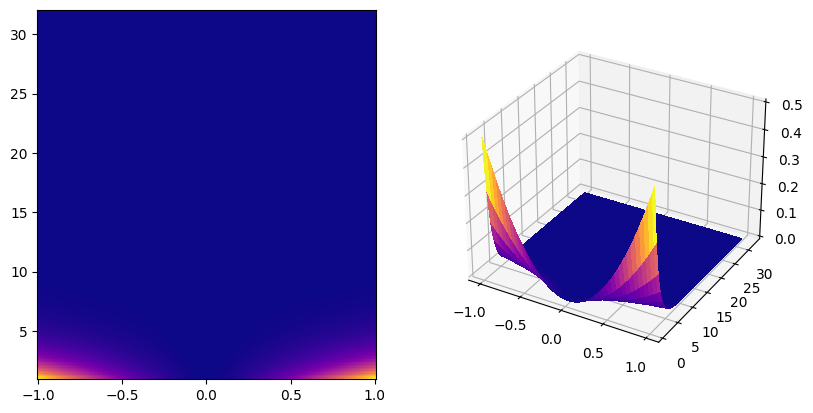

In [360]:
mk_plot(probabilty_from_correlation)

 helpers:

In [361]:
def _reversed_num_to_bool_list_generator(num:int):
    if num<0:
        raise ValueError("number must be positive")
    else:
        while num > 0:
            yield bool(num % 2)
            num //= 2 # num <<=1

def _int_to_boollist(num:int):
    l = [x for x in _reversed_num_to_bool_list_generator(num)]
    l.reverse()
    return l

def _boollist_to_int(bools:List[bool])->int:
    out = 0
    for bit in bools:
        out = (out << 1) | bit
    return out

def _try_and_handle(func, handle=lambda e:e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return handle(e)

__err_count__iuweghfhksjdf__ = 0
def _zip_and_fill_with(*gs, fill=0):
    max_errs = len(gs)
    while True:
        global __err_count__iuweghfhksjdf__
        def handle(e):
            global __err_count__iuweghfhksjdf__
            __err_count__iuweghfhksjdf__+=1
            return fill
        yield [_try_and_handle(lambda: next(g), handle=handle) for g in gs]
        if __err_count__iuweghfhksjdf__>=max_errs:
            __err_count__iuweghfhksjdf__ = 0
            return

def _Boolean_scalar_product_of_ints(x1:int,x2:int)->bool:
    g = lambda z : _reversed_num_to_bool_list_generator(z)
    # return [x1_i * x2_i for x1_i , x2_i in _zip_and_fill_with(g(x1),g(x2),fill=0)]
    return bool(sum(x1_i * x2_i for x1_i , x2_i in _zip_and_fill_with(g(x1),g(x2),fill=0))%2)

In [362]:
_Boolean_scalar_product_of_ints(0b10,0b10) #doesnt work?

True

In [363]:
def eval_correlation(f:Callable[[int],bool], register_size:int)->float:
    max_val = 2**register_size
    # correlation =0
    # for i in range(0,max_val):
    #     correlation += (-1)**f(i)
    return sum((2*f(i)-1) for i in range(max_val))/max_val

In [364]:
def test_f(x:int)->bool:
    return x%2

eval_correlation(test_f,1)

0.0

In [365]:
def _t_bar(mask_x:int, mask_y:int,f:Callable[[int],int],x)->bool:
    """
    mask_x: x-mask (f input)
    mask_y: y-mask (f output)
    f: function x->y on which the masks are applied
    x: input to evaluate
    """
    return _Boolean_scalar_product_of_ints(mask_x,x) == _Boolean_scalar_product_of_ints(mask_y,f(x))

def t_bar_of_f(mask_x:int, mask_y:int,f:Callable[[int],int])->Callable[[int],bool]:
    """
    returns a function that says whether the given linear approximation (masks) (given as int, int) evaluates to true at given x
    """
    return lambda x : _t_bar(mask_x, mask_y,f,x)

# main decorator
def t_bar(mask_x:int, mask_y:int)->Callable[[Callable[[int],int]],Callable[[int],bool]]:
    """
    a decorator to 
    turn any Boolean mapping (given as f: int->int) into 
    an evaluator that says whether the given linear approximation (masks) (again given as int, int) 
    is true at given x

    Example:
        @t_bar(_boollist_to_int([0,1]),1)
        def test_f(x:int)->int:
            return x%2
    """
    return lambda f : t_bar_of_f(mask_x,mask_y,f)


In [366]:
@t_bar(_boollist_to_int([1,1]),1)
def test_f(x:int)->int:
    return x%2

eval_correlation(test_f,2)

# # should be 00=0:True , 01=1:True, 10=0:False, 11=1:False
# test_f(0),test_f(1),test_f(2),test_f(3)

0.0

In [367]:
def __distorted_sum_of_t_bar_correlation(f:Callable[[int],int], input_register_size:int, output_register_size:int, distortion=lambda x:x):
    max_val_in, max_val_out = 2**input_register_size, 2**output_register_size
    # return [(mask_in,mask_out,'->',eval_correlation(t_bar(mask_in,mask_out)(f),input_register_size)) for mask_out in range(max_val_out) for mask_in in range(max_val_in)]
    # return [eval_correlation(t_bar(mask_in,mask_out)(f),input_register_size) for mask_out in range(max_val_out) for mask_in in range(max_val_in)]
    return sum(distortion(eval_correlation(t_bar(mask_in,mask_out)(f),input_register_size)) for mask_out in range(max_val_out) for mask_in in range(max_val_in))

def test_f_not_t_barred(x:int)->int:
    switch = {
        0b000:0,
        0b001:0,
        0b010:0,
        0b011:1,
        0b100:0,
        0b101:0,
        0b110:0,
        0b111:1
    }
    return switch[x]

n_y = 1
n_x = 3
# okay das dient ein bisschen als test, eigentlich sollte hier bei dem quadrierten immer 1 rauskommen?


In [368]:
threshold = 0.4/n_y

In [369]:
(
# __distorted_sum_of_t_bar_correlation(test_f_not_t_barred,n_x,n_y)/(2**n_y) , 
__distorted_sum_of_t_bar_correlation(test_f_not_t_barred,n_x,n_y,distortion=lambda x:x**2/(2**n_y)),
__distorted_sum_of_t_bar_correlation(test_f_not_t_barred,n_x,n_y,distortion=lambda x:1 if x>threshold else 0),
# __distorted_sum_of_t_bar_correlation(test_f_not_t_barred,n_x,n_y,distortion=lambda x:x**3/(2**n_y)), 
# __distorted_sum_of_t_bar_correlation(test_f_not_t_barred,n_x,n_y,distortion=lambda x:x**6/(2**n_y)), 
# __distorted_sum_of_t_bar_correlation(test_f_not_t_barred,n_x,n_y,distortion=lambda x:2**x/(2**n_y))
)

(1.0, 4)

In [370]:
prefix = 'malviya'
inl = 4
outl = 4

def f_malviya(x:int)->int:
    #e 4 d 1 2 f b 8 3 a 6 c 5 9 0 7
    values = [
        0xE ,    
        0x4 ,
        0xD ,
        0x1 ,
        0x2 ,
        0xF ,
        0xB ,
        0x8 ,
        0x3 ,
        0xA ,
        0x6 ,
        0xC ,
        0x5 ,
        0x9 ,
        0x0 ,
        0x7
    ]
    return values[x]

def f(x):
    return f_malviya(x)

if True:    
    prefix = '8to8random2'
    inl = 8
    outl = 8

    def f(x:int)->int:
        return np.random.randint(0,2**outl)
        # mask = 0b1010101010101010
        # return x ^ (f_malviya(x)&mask)
        ret = (x^0xC) | ((f_malviya(x)&0x3)<<4)
        # print(f'{ret:08b}')
        return ret
        # x = x^0xCAFEBABE
        # return _boollist_to_int([
        #     _Boolean_scalar_product_of_ints(x,0xCA),
        #     _Boolean_scalar_product_of_ints(x,0xFE),
        #     _Boolean_scalar_product_of_ints(x,0xBA),
        #     _Boolean_scalar_product_of_ints(x,0xBE),
        #     _Boolean_scalar_product_of_ints(x,0x03),
        #     _Boolean_scalar_product_of_ints(x,0x0B),
        #     _Boolean_scalar_product_of_ints(x,0xE0),
        #     _Boolean_scalar_product_of_ints(x,0xDD)
        # ])

In [371]:

class CorrData:
    corr = 0
    mask_x = 0
    mask_y = 0

    def __init__(self, corr, mask_x, mask_y):
        self.corr = corr
        self.mask_x = mask_x
        self.mask_y = mask_y

    def __lt__(self, other):
        return self.corr < other.corr
    
    def __repr__(self):
        return f"{self.mask_x:04b}->{self.mask_y:04b} : {self.corr}"
    
    def copy_as_abs(self):
        return CorrData(abs(self.corr), self.mask_x, self.mask_y)

correlations = [CorrData(eval_correlation(t_bar(mask_in,mask_out)(f),inl), mask_in, mask_out) for mask_out in range(2**outl) for mask_in in range(2**inl)]
abs_correlations = [corr.copy_as_abs() for corr in correlations]

filtered_correlations = list(filter(lambda corr: corr.mask_y == 0xFF, correlations))
filtered_correlations.sort(reverse=True)
print(filtered_correlations)
# sort desc
correlations.sort()
abs_correlations.sort()

print(abs_correlations[::-1])

# count how many have a given correlation
correlation_counts = {}
for corr in correlations:
    if corr.corr not in correlation_counts:
        correlation_counts[corr.corr] = 0
    correlation_counts[corr.corr] += 1

abs_correlation_counts = {}
for corr in abs_correlations:
    if corr.corr not in abs_correlation_counts:
        abs_correlation_counts[corr.corr] = 0
    abs_correlation_counts[corr.corr] += 1

correlation_counts, abs_correlation_counts

# plot the correlation counts, with each bar named and their value also written at their top
# fig_counts = plt.figure(figsize=plt.figaspect(.5))
# plt.bar(correlation_counts.keys(), correlation_counts.values(), width=0.2, color='g', align='center')
# for k,v in correlation_counts.items():
#     plt.text(k,v,v)
# plt.show()


[10000110->11111111 : 0.21875, 11011110->11111111 : 0.1484375, 10001111->11111111 : 0.125, 11010010->11111111 : 0.125, 11110000->11111111 : 0.125, 111011->11111111 : 0.1171875, 10011111->11111111 : 0.1171875, 10110011->11111111 : 0.1171875, 11100->11111111 : 0.109375, 101000->11111111 : 0.109375, 10010001->11111111 : 0.109375, 11001010->11111111 : 0.109375, 11101101->11111111 : 0.1015625, 10001000->11111111 : 0.09375, 11100000->11111111 : 0.09375, 10000->11111111 : 0.0859375, 1001001->11111111 : 0.0859375, 1010111->11111111 : 0.0859375, 10100011->11111111 : 0.0859375, 10101110->11111111 : 0.0859375, 11011010->11111111 : 0.0859375, 11101011->11111111 : 0.0859375, 11111001->11111111 : 0.0859375, 110100->11111111 : 0.078125, 1001110->11111111 : 0.078125, 10000100->11111111 : 0.078125, 10110101->11111111 : 0.078125, 11010001->11111111 : 0.078125, 0000->11111111 : 0.0703125, 0010->11111111 : 0.0703125, 10101->11111111 : 0.0703125, 110010->11111111 : 0.0703125, 1000011->11111111 : 0.0703125,

({-0.2578125: 1,
  -0.2421875: 1,
  -0.234375: 1,
  -0.2265625: 6,
  -0.21875: 5,
  -0.2109375: 10,
  -0.203125: 22,
  -0.1953125: 16,
  -0.1875: 41,
  -0.1796875: 42,
  -0.171875: 84,
  -0.1640625: 108,
  -0.15625: 143,
  -0.1484375: 186,
  -0.140625: 269,
  -0.1328125: 361,
  -0.125: 422,
  -0.1171875: 584,
  -0.109375: 721,
  -0.1015625: 807,
  -0.09375: 1034,
  -0.0859375: 1219,
  -0.078125: 1449,
  -0.0703125: 1757,
  -0.0625: 1957,
  -0.0546875: 2190,
  -0.046875: 2452,
  -0.0390625: 2751,
  -0.03125: 2905,
  -0.0234375: 2977,
  -0.015625: 3193,
  -0.0078125: 3201,
  0.0: 3489,
  0.0078125: 3231,
  0.015625: 3111,
  0.0234375: 3015,
  0.03125: 2799,
  0.0390625: 2705,
  0.046875: 2469,
  0.0546875: 2304,
  0.0625: 2034,
  0.0703125: 1756,
  0.078125: 1417,
  0.0859375: 1281,
  0.09375: 1067,
  0.1015625: 903,
  0.109375: 685,
  0.1171875: 565,
  0.125: 464,
  0.1328125: 355,
  0.140625: 267,
  0.1484375: 228,
  0.15625: 139,
  0.1640625: 106,
  0.171875: 69,
  0.1796875: 52,
  0.

In [372]:
list(filter(lambda corr: corr.corr != 0, correlations[::-1]))

[0000->0000 : 1.0,
 1011001->10001010 : 0.2890625,
 11010001->11110010 : 0.2578125,
 11011->10010100 : 0.2578125,
 11110101->101110 : 0.2421875,
 11000100->11000111 : 0.234375,
 1010000->10010011 : 0.234375,
 10101->1100010 : 0.234375,
 0011->11001101 : 0.2265625,
 1110001->11001010 : 0.2265625,
 10001100->11000110 : 0.2265625,
 110000->10010010 : 0.2265625,
 1100110->1011001 : 0.2265625,
 1110101->1010100 : 0.2265625,
 1001->1000111 : 0.2265625,
 101010->11101 : 0.2265625,
 10000110->11111111 : 0.21875,
 11001010->11111110 : 0.21875,
 10101000->11000101 : 0.21875,
 1001111->10101101 : 0.21875,
 1011001->10010111 : 0.21875,
 1000111->1110010 : 0.21875,
 1111100->100111 : 0.21875,
 0001->11110010 : 0.2109375,
 1010111->11011101 : 0.2109375,
 10001001->11001100 : 0.2109375,
 10101001->10111011 : 0.2109375,
 10001110->10101101 : 0.2109375,
 101101->10011111 : 0.2109375,
 11001101->10000111 : 0.2109375,
 11110000->1100110 : 0.2109375,
 11011101->1100010 : 0.2109375,
 10010111->1011100 : 0.

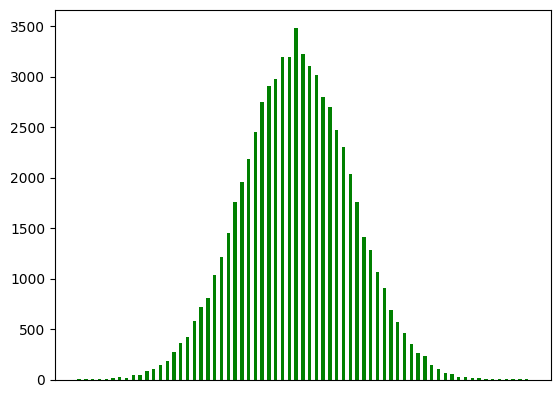

In [380]:
import tikzplotlib

# get tikz code and save it to a file

# fig = plt.figure(figsize=plt.figaspect(.5))
plt.bar([f'{key}' for key in correlation_counts.keys()], correlation_counts.values(), width=0.5, color='g', align='center')
if '8to8random' not in prefix:
    for i,(k,v) in enumerate(correlation_counts.items()):
        plt.text(i,v,v)
else:
    #disable x labels
    plt.xticks([])

plt.xticks(rotation=90)

tikzplotlib.save("empirical/"+prefix+"_correlation_counts.tex")


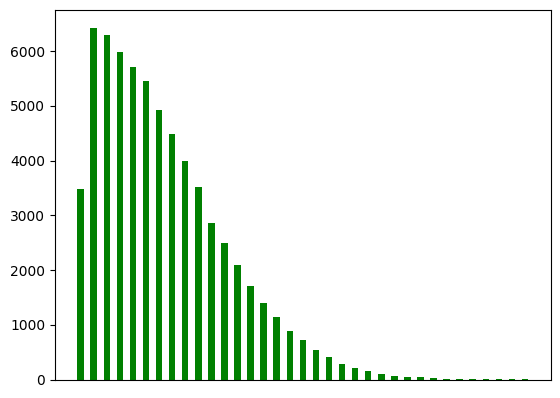

In [379]:

# fig = plt.figure(figsize=plt.figaspect(.5))

plt.bar([f'{key}' for key in abs_correlation_counts.keys()], abs_correlation_counts.values(), width=0.5, color='g', align='center')

if '8to8random' in prefix:
    plt.xticks([])

else:
    for i,(k,v) in enumerate(abs_correlation_counts.items()):
        plt.text(i,v,v)

tikzplotlib.save("empirical/"+prefix+"_abs_correlation_counts.tex")

67 128.0


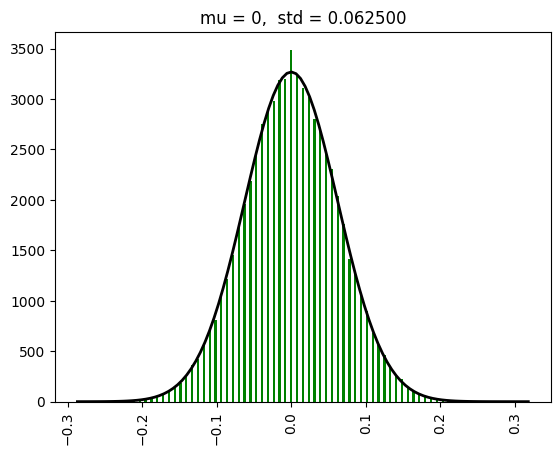

In [405]:
# if prefix contains 'random'
if 'random' in prefix:
    # plt.xticks([])
    plt.xticks(rotation=90)
    plt.bar(list(correlation_counts.keys())[:-1], list(correlation_counts.values())[:-1], width=0.003, color='g', align='center')
    from scipy.stats import norm
    mu, std = 0, 1/(inl*3-outl)
    xmin, xmax = plt.xlim()
    print(len(correlation_counts), 1/(list(correlation_counts.keys())[23]-list(correlation_counts.keys())[22]))
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)*2**(outl+1)
    plt.plot(x, p, 'k', linewidth=2)
    title = "mu = %i,  std = %f" % (mu, std)
    plt.title(title)
    tikzplotlib.save("empirical/"+prefix+"_correlation_counts_normfit.tex")
    

[0.0, 0.0245361328125, 0.09619140625, 0.205718994140625, 0.34814453125, 0.52032470703125, 0.6757965087890625, 0.8400192260742188, 0.974365234375, 1.0854835510253906, 1.093292236328125, 1.1539459228515625, 1.15411376953125, 1.1024093627929688, 1.051239013671875, 0.9861946105957031, 0.865234375, 0.7893524169921875, 0.6624755859375, 0.5701217651367188, 0.4302978515625, 0.36000823974609375, 0.2824859619140625, 0.18968963623046875, 0.1494140625, 0.10251998901367188, 0.1057281494140625, 0.066741943359375, 0.035888671875, 0.04491424560546875, 0.01373291015625, 0.00733184814453125, 0.012462615966796875, 0.005222320556640625, 0.0625]


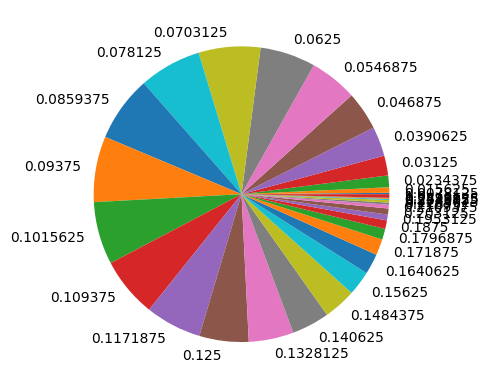

In [376]:
# fig = plt.figure(figsize=plt.figaspect(.5))

probs = [count*corr*corr for corr, count in abs_correlation_counts.items()]
print([prob/2**4 for prob in probs])

plt.pie(probs[1:],labels = [f'{key}' for key in abs_correlation_counts.keys()][1:], )
# for k,v in abs_correlation_counts.items():
#     plt.text(k*4,v,v)

tikzplotlib.save("empirical/"+prefix+"_probability_pie.tex")

x%2:
(0, 0 -> 1.0),
(0, 1 -> 0.5),
(1, 0 -> 0.0),
(1, 1 -> 0.5),
(2, 0 -> 0.0),
(2, 1 -> -0.5),
(3, 0 -> 0.0),
(3, 1 -> 0.5)

klar, wenn das output nicht interessiert, dann ist die correlation immer 0 (ausser das input interressiert auch nicht, dann corr=1)
wenn es interessiert, und die corr eines bestimmten bits von 1 auf x sinkt...

Mein Kopf raucht, aber ich kanns intuitiv nicht verstehen .. :(

In [377]:
# mk_plot(lambda x,y : (int)(eval_correlation(t_bar(x,y)(test_f_not_t_barred),n_x)*1000), range_x = 2**n_x, range_y = 2**n_y)# dang doenst work since numpy is used

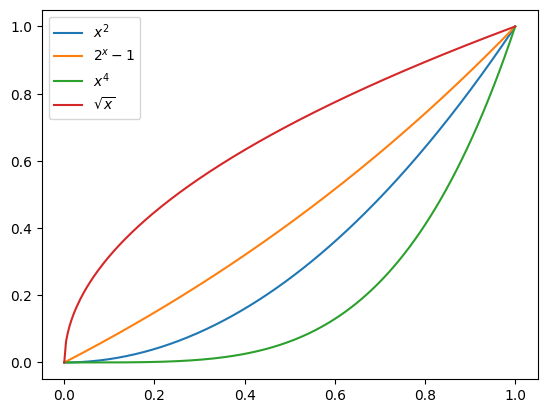

In [378]:
# plot x^2 , 2^x-1 , x^4, sqrt(x) for x in [0,1]

_sample_count = 256

range_x = np.linspace(0,1, _sample_count)

plt.plot(range_x, range_x**2, label='$x^2$')
plt.plot(range_x, 2**range_x-1, label='$2^x-1$')
plt.plot(range_x, range_x**4, label='$x^4$')
plt.plot(range_x, range_x**0.5, label=r'$\sqrt{x}$')
# plt.plot(range_x, np.sinh(range_x), label='sinh(x)')
plt.legend()
# plt.show()

tikzplotlib_fix_ncols(plt.gcf())

tikzplotlib.save("activation_functions.tex")
